## Exploración y entendimiento profundo de los datos ##

Librerias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Datos:

In [2]:
PATH = "C:/Users/pauli/Documents/MetodosGranEscala/Prediccion_de-_demanda_en_retail/Data/"
#PATH = "/Users/monserratarredondo/GitHub/Prediccion_de-_demanda_en_retail/Data/"

item_categories = pd.read_csv(PATH + "item_categories.csv", encoding='utf-8', low_memory=False)
items= pd.read_csv(PATH + "items.csv", encoding='utf-8', low_memory=False)
sales_train = pd.read_csv(PATH + "sales_train.csv", encoding='utf-8', low_memory=False)
sample_submission = pd.read_csv(PATH + "sample_submission.csv", encoding='utf-8', low_memory=False)
shops = pd.read_csv(PATH + "shops.csv", encoding='utf-8', low_memory=False)
test = pd.read_csv(PATH + "test.csv", encoding='utf-8', low_memory=False)

In [3]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [4]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB


In [5]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


*Exploración sobre datos históricos de ventas diarias (2013-2015)*

In [7]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [8]:
sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


*Combinaciones producto-tienda para predicción*

In [10]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


*Información de productos y categorías*

In [11]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


Objetivo

- item_cnt_month = suma de item_cnt_day por (date_block_num, shop_id, item_id)
(esto es lo que Kaggle evalúa)

Predictoras base

- Identificadores: shop_id, item_id, date_block_num (mes)
- Precio: item_price (luego lo usas como media/mediana mensual, etc.)
- Info del producto: item_category_id (viene de items.csv)
- Info de tienda: shop_name (puedes extraer ciudad/cluster después si quieres)

Derivadas útiles

- revenue_day = item_price * item_cnt_day (y su versión mensual)
- Estadísticos mensuales: media de precio, etc.

In [12]:
# Copia para no ensuciar el df original
sales = sales_train.copy()

# Fecha a datetime (en este dataset viene como "dd.mm.yyyy")
sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y", errors="coerce")

# Limpieza rápida (cosas raras que sí afectan features)
sales = sales[(sales["item_price"] > 0) & (sales["item_cnt_day"] >= 0)].copy()

# Ingreso diario
sales["revenue_day"] = sales["item_price"] * sales["item_cnt_day"]

print("Rango fechas:", sales["date"].min(), "→", sales["date"].max())
print("Nulos en date:", sales["date"].isna().sum())

Rango fechas: 2013-01-01 00:00:00 → 2015-10-31 00:00:00
Nulos en date: 0


Construir la tabla mensual (aquí nace la variable objetivo)

In [13]:
monthly = (
    sales.groupby(["date_block_num", "shop_id", "item_id"], as_index=False)
    .agg(
        item_cnt_month=("item_cnt_day", "sum"),     # <-- target
        item_price_mean=("item_price", "mean"),
        revenue_month=("revenue_day", "sum"),
        days_obs=("date", "nunique"),
    )
)

# Enriquecer con categoría (para EDA y luego features)
monthly = monthly.merge(items[["item_id", "item_category_id"]], on="item_id", how="left")

print(monthly.shape)
monthly.head()


(1608226, 8)


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,revenue_month,days_obs,item_category_id
0,0,0,32,6.0,221.0,1326.0,4,40
1,0,0,33,3.0,347.0,1041.0,3,37
2,0,0,35,1.0,247.0,247.0,1,40
3,0,0,43,1.0,221.0,221.0,1,40
4,0,0,51,2.0,128.5,257.0,2,57


Sanity check del target (distribución + outliers)

count    1.608226e+06
mean     2.273154e+00
std      8.653236e+00
min      1.000000e+00
50%      1.000000e+00
90%      4.000000e+00
95%      6.000000e+00
99%      1.700000e+01
max      2.253000e+03
Name: item_cnt_month, dtype: float64
Mes-producto-tienda con 0 ventas: 0.0


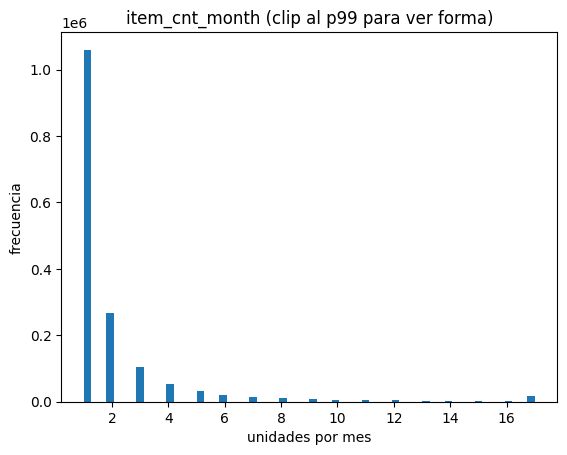

In [15]:
y = monthly["item_cnt_month"]

print(y.describe(percentiles=[.5, .9, .95, .99]))
print("Mes-producto-tienda con 0 ventas:", (y == 0).mean().round(4))

plt.figure()
plt.hist(y.clip(upper=y.quantile(0.99)), bins=60)
plt.title("item_cnt_month (clip al p99 para ver forma)")
plt.xlabel("unidades por mes")
plt.ylabel("frecuencia")
plt.show()


Patrón temporal global (¿hay estacionalidad?)

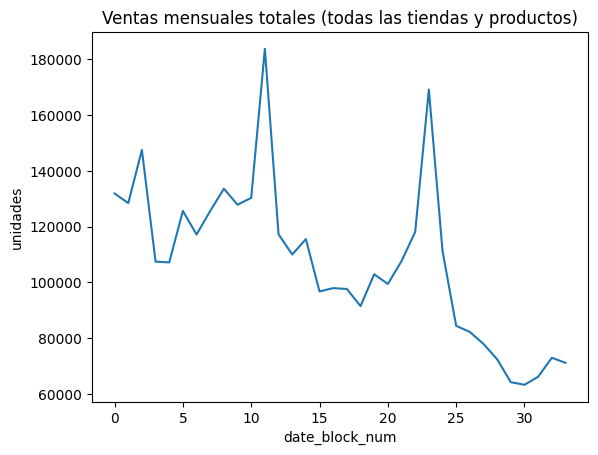

In [16]:
ts = monthly.groupby("date_block_num", as_index=False)["item_cnt_month"].sum()

plt.figure()
plt.plot(ts["date_block_num"], ts["item_cnt_month"])
plt.title("Ventas mensuales totales (todas las tiendas y productos)")
plt.xlabel("date_block_num")
plt.ylabel("unidades")
plt.show()

¿Quién carga el volumen? (tiendas / categorías)

In [17]:
top_shops = (
    monthly.groupby("shop_id")["item_cnt_month"].sum()
    .sort_values(ascending=False)
    .head(10)
)
print("Top 10 tiendas por unidades:")
print(top_shops)

top_cats = (
    monthly.groupby("item_category_id")["item_cnt_month"].sum()
    .sort_values(ascending=False)
    .head(10)
)
print("\nTop 10 categorías por unidades:")
print(top_cats)


Top 10 tiendas por unidades:
shop_id
31    311230.0
25    242237.0
54    186149.0
28    184777.0
42    145195.0
57    141424.0
27    136815.0
6     100757.0
58     81908.0
46     79092.0
Name: item_cnt_month, dtype: float64

Top 10 categorías por unidades:
item_category_id
40    634885.0
30    457359.0
55    349050.0
19    255756.0
37    204031.0
71    188016.0
28    175227.0
23    170577.0
20    127763.0
65     73103.0
Name: item_cnt_month, dtype: float64


Precio vs demanda

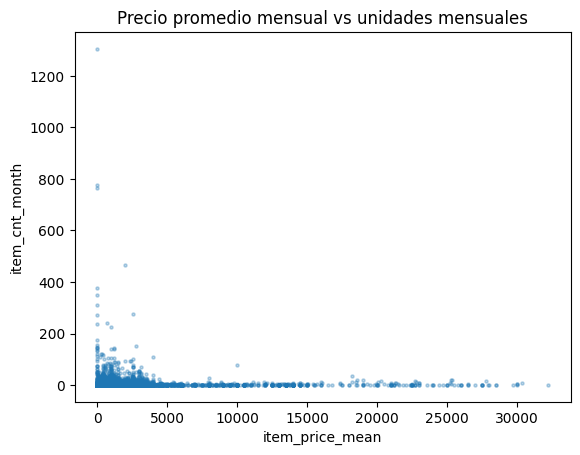

Corr (Spearman) precio vs demanda: 0.168


In [18]:
sample = monthly.sample(50000, random_state=42) if len(monthly) > 50000 else monthly

plt.figure()
plt.scatter(sample["item_price_mean"], sample["item_cnt_month"], s=5, alpha=0.3)
plt.title("Precio promedio mensual vs unidades mensuales")
plt.xlabel("item_price_mean")
plt.ylabel("item_cnt_month")
plt.show()

print("Corr (Spearman) precio vs demanda:",
      sample[["item_price_mean","item_cnt_month"]].corr(method="spearman").iloc[0,1].round(3))
